# Paws and Prediction
## Overview of the project
0. Import libraries
1. Load and transform data
2. Visualize data
3. Import model
4. Perform feature analysis of model output

In [1]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import Subset

import time
from sklearn.metrics import classification_report

In [2]:
## for gpu usage, check true
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## 1. Load and transform data

We might want to think about how we transform the data and the splitting
Also about the size (now [3, 384, 384]), will probably require a lot of compute to train? Look up what seems reasonable

""The inference transforms are available at EfficientNet_B4_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[384] using interpolation=InterpolationMode.BICUBIC, followed by a central crop of crop_size=[380]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].""


####ser ut som att man kan addera random augmentations :))

def get_train_transform(IMAGE_SIZE, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    retur

In [5]:
#TODO - load data much faster

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if int(target) in self.label_map:
            target = self.label_map[target]
        return image, target
class LoadData:
    def __init__(self, binary=True):
        self.transform = self.transform_images()

        if binary:
            self.classes = 2  # Might not be necessary
            self.label_map = self.initialize_label_map()  # Initialize label_map for binary classification
            self.bin_dataset()
        else:
            self.classes = 37
            self.mult_dataset()

    def initialize_label_map(self):
        """Initialize the label map for binary classification."""
        # Dictionary mapping original labels to binary labels
        label_dict = {
            0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0,
            6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1,
            13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1,
            19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1,
            25: 1, 26: 0, 27: 0, 28: 1, 29: 1, 30: 1,
            31: 1, 32: 0, 33: 0, 34: 1, 35: 1, 36: 1
        }
        return label_dict

    def bin_dataset(self):
        """Load the binary dataset."""
        # Use the initialized label map
        self.dataset_trainval = CustomOxfordPets(
            root='./data', transform=self.transform, download=True, label_map=self.label_map, split='trainval'
        )
        self.test_dataset = CustomOxfordPets(
            root='./data', transform=self.transform, download=True, label_map=self.label_map, split='test'
        )


    def data_loaders(self, batch_size, split_ratio, labeled_percent = 1):
        """Initialize dataloaders."""
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        if labeled_percent <1:
          pseudo_train_size = int(labeled_percent *train_size)

          pseudo_guess_size =  train_size -pseudo_train_size
          train_pseudo, guess_pseudo = random_split(train_dataset, [pseudo_train_size, pseudo_guess_size])

          self.trainPseudo_loader =  DataLoader(train_pseudo, batch_size=batch_size, shuffle=True)
          self.guess_loader = DataLoader(guess_pseudo, batch_size=batch_size, shuffle=True)


        else:
          self.trainPseudo_loader = [];
          self.guess_loader = [];



        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)

    def transform_images(self):
        transform = transforms.Compose([
            transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(380),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform





## 2. Train Class to initialize all training

In [4]:

class Train:
    def __init__(self, lr: float, bs: int, epochs: int, split_ratio: float, binary: bool, model, _LoadData=LoadData(), labeled_percent = 1):
        self.lr = lr
        self.batch_size = bs
        self.split_ratio = split_ratio
        self.epochs = epochs
        self.binary = binary

        self.color1 = '#FF6347'
        self.color2 = '#01A4B4'

        self.labeled_percent = labeled_percent
        self.data = _LoadData #kom på snyggare variablenamn
        self.data.data_loaders(self.batch_size, self.split_ratio, labeled_percent=self.labeled_percent)

        self.train_loader = self.data.train_loader
        self.val_loader = self.data.val_loader
        self.test_loader = self.data.test_loader

        self.train_pseudo_loader = self.data.trainPseudo_loader

        self.guess_loader = self.data.guess_loader

        self.model = self.load_model()
        if model is not None:
            self.model = torch.load(model) #kolla upp hur vi laddar in färdigtränade modeller för detta funkar inte

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #
        print('Using gpu: %s ' % torch.cuda.is_available())

        self.validation_losses = [] #eller vill jag initialisera det i träningsfunktionen?
        self.training_losses = []

        self.loss_func = nn.BCEWithLogitsLoss() #fixa för binare
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=self.lr)


    def load_model(self):
        """Load the weights of the model"""
        model_b4 = models.efficientnet_b4(weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1)

        # TODO - fundera på om vi vill frysa alla lager
        for param in model_b4.parameters(): #Freeze
            param.requires_grad = False

        num_features = model_b4.classifier[1].in_features

        # Replace the classifier layer
        model_b4.classifier[1] = nn.Linear(num_features, 1)

        return model_b4

    def pseudo_labels(self, lr_mult):
        self.model.train() #Bör inte störa "freezed" layers
        self.model.to(self.device)

        start_time = time.time()  # Start timing


        modified_dataset = []

        print(self.lr*lr_mult)

        optimizer = optim.Adam(self.model.classifier.parameters(), lr=self.lr*lr_mult)
        for epoch in range(self.epochs):
            for images, labels in self.train_pseudo_loader:

                labels = labels.float()

                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.loss_func(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()


        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Pseudo training finished in {elapsed_time:.2f} seconds')


        self.model.eval()
        count_similar = 0

        for images, labels in self.train_pseudo_loader:
          images, labels = images.to("cpu"), labels.to("cpu")
          for image_idx, image in enumerate(images):
            for label_idx, label in enumerate(labels):
                if label_idx == image_idx:
                  modified_dataset.append((image, label.item()))
                  break


        print("Pass first loop")

        for images, labels in self.guess_loader:

              images = images.to(self.device)
              outputs = [1 if output > 0.5 else 0 for output in torch.sigmoid(self.model(images))]
              images, labels = images.to("cpu"), labels.to("cpu")

              labels_cpu = labels.cpu()  # Move to CPU
              labels_np = labels_cpu.numpy()
              count_similar += np.sum(np.array([1 if label > 0.5 else 0 for label in labels_np]) == np.array(outputs))

              j = 0
              for image in images:

                modified_dataset.append((image, outputs[j]))
                j += 1
        accuracy = count_similar/(len(self.guess_loader)*self.batch_size)


        print("Accuracy on test set for pseudo: ", np.round(accuracy, 4))
        print("pass second loop")
        print(str(len(modified_dataset)))

        #shuffle true eller false här?
        self.train_loader = DataLoader(modified_dataset, batch_size=self.batch_size, shuffle=True)



    def train(self):
        """Train the network"""

        self.model.train() #Bör inte störa "freezed" layers
        self.model.to(self.device)

        train_loss = self.compute_loss(train.train_loader) #epoch_loss / len(self.train_loader.dataset)
        val_loss = self.compute_loss(train.val_loader)

        self.training_losses.append(train_loss)
        self.validation_losses.append(val_loss)

        start_time = time.time()  # Start timing

        for epoch in range(self.epochs):
            for images, labels in self.train_loader:
                labels = labels.float()  #Läste att det kunde vara viktigt
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels.unsqueeze(1))
                loss.backward()
                self.optimizer.step()

            # Compute validation loss
            train_loss = self.compute_loss(train.train_loader)
            val_loss = self.compute_loss(train.val_loader)
            print(f'Epoch {epoch+1}, Training Loss: {train_loss} \t Validation Loss: {val_loss}')

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)

        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Training finished in {elapsed_time:.2f} seconds')

        accuracy_val = self.evaluate(self.val_loader)
        accuracy_test = self.evaluate(self.test_loader)

        return accuracy_test

    def plot_loss_curves(self):
        """plot the loss on the training and validation set during training"""
        epochs = np.arange(0, len(self.training_losses))

        plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
        plt.plot(epochs, self.training_losses, color=self.color1, linewidth=2.5, label='Training Loss')
        plt.plot(epochs, self.validation_losses, color=self.color2, linewidth=2.5, label='Validation Loss')
        plt.xlabel('Epoch')  # Adjust the fontsize as needed
        plt.ylabel('Loss')    # Adjust the fontsize as needed
        plt.legend(loc='upper right')
        plt.tight_layout()

        plt.savefig(f'lr{self.lr}_epochs{self.epochs}.png', dpi=600)
        plt.show()


    def compute_loss(self, dataloader):
        """Compute the loss on the validation set"""
        self.model.eval()
        epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloader:
                labels = labels.float()
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels.unsqueeze(1))
                epoch_loss += loss.item() * images.size(0)
        epoch_loss /= len(dataloader)
        self.model.train()
        return epoch_loss


    def evaluate(self, dataloader):
        """Compute the accuracy of the model"""
        self.model.eval()
        count_similar = 0

        self.test_y = []
        self.pred_y = []

        for images, labels in dataloader:
            self.test_y.extend(labels.cpu().numpy().flatten())
            labels = labels.float()

            images, labels = images.to(self.device), labels.to(self.device)
            outputs = [1 if output > 0.5 else 0 for output in torch.sigmoid(self.model(images))]
            labels_cpu = labels.cpu()
            labels_np = labels_cpu.numpy()
            count_similar += np.sum(np.array([1 if label > 0.5 else 0 for label in labels_np]) == np.array(outputs))
            self.pred_y.extend(outputs)

        accuracy = count_similar/(len(dataloader)*self.batch_size)

        if dataloader == self.test_loader:
            print(f'Accuracy of Test: {accuracy:.4f}')
        if dataloader == self.val_loader:
            print(f'Accuracy of Val: {accuracy:.4f}')

        return np.round(accuracy, 4)


    def classification_report(self):
        if self.test_y is None or self.pred_y is None:
            self.evaluate()

        test_class_names = ['dog' if label == 0 else 'cat' for label in self.test_y]
        pred_class_names = ['dog' if label == 0 else 'cat' for label in self.pred_y]

        class_report = classification_report(test_class_names, pred_class_names)
        print(class_report)
        return class_report



# Below is accuracy for binary without pseudo



## Bästa inställningen:

### 16 epoker

Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 2.3606510564036993 	 Validation Loss: 2.379792834105699
Epoch 2, Training Loss: 1.4877099244166976 	 Validation Loss: 1.4946752812551416
Epoch 3, Training Loss: 1.1132430212329263 	 Validation Loss: 1.1257435472115227
Epoch 4, Training Loss: 0.860764876736895 	 Validation Loss: 0.8654696499199971
Epoch 5, Training Loss: 0.7215586335033827 	 Validation Loss: 0.7343884411713352
Epoch 6, Training Loss: 0.6366919928999699 	 Validation Loss: 0.6449291024195112
Epoch 7, Training Loss: 0.5841117965502908 	 Validation Loss: 0.5943344586893268
Epoch 8, Training Loss: 0.47341634284542955 	 Validation Loss: 0.48192407547131827
Epoch 9, Training Loss: 0.4502876579113629 	 Validation Loss: 0.47039937956825545
Epoch 10, Training Loss: 0.36969816350661544 	 Validation Loss: 0.3716124237879463
Epoch 11, Training Loss: 0.4172796651761493 	 Validation Loss: 0.4343246245027884
Epoch 12, Training Loss: 0.3444581559008878 	 Validation Loss: 

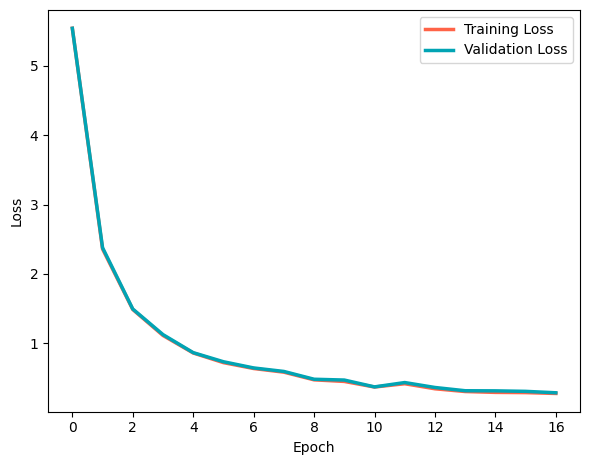

              precision    recall  f1-score   support

         cat       0.99      1.00      0.99      2486
         dog       1.00      0.97      0.99      1183

    accuracy                           0.99      3669
   macro avg       0.99      0.99      0.99      3669
weighted avg       0.99      0.99      0.99      3669



'              precision    recall  f1-score   support\n\n         cat       0.99      1.00      0.99      2486\n         dog       1.00      0.97      0.99      1183\n\n    accuracy                           0.99      3669\n   macro avg       0.99      0.99      0.99      3669\nweighted avg       0.99      0.99      0.99      3669\n'

In [9]:
_LoadData = LoadData(binary=True)
train = Train(lr=0.0005, bs=8, epochs=16, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
print("bs is " + str(8) + " and lr is " + str(0.0005))
train.train()
train.plot_loss_curves()
train.classification_report()

### 32 epoker

Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 2.369237634798755 	 Validation Loss: 2.434536761563757
Epoch 2, Training Loss: 1.4803010254450466 	 Validation Loss: 1.5647543403117552
Epoch 3, Training Loss: 1.1300330627709627 	 Validation Loss: 1.2207342901307603
Epoch 4, Training Loss: 0.8723167058728312 	 Validation Loss: 0.9397694212586983
Epoch 5, Training Loss: 0.7705223576125243 	 Validation Loss: 0.8488693227586539
Epoch 6, Training Loss: 0.6082231098705012 	 Validation Loss: 0.6823015587161416
Epoch 7, Training Loss: 0.5213417339179179 	 Validation Loss: 0.5901413747797841
Epoch 8, Training Loss: 0.4816410794206288 	 Validation Loss: 0.5457219755196053
Epoch 9, Training Loss: 0.39689470090619894 	 Validation Loss: 0.45864799999348493
Epoch 10, Training Loss: 0.4138893848690002 	 Validation Loss: 0.48160523151897866
Epoch 11, Training Loss: 0.34302315812395967 	 Validation Loss: 0.4092542603611946
Epoch 12, Training Loss: 0.32216862506111676 	 Validation Loss:

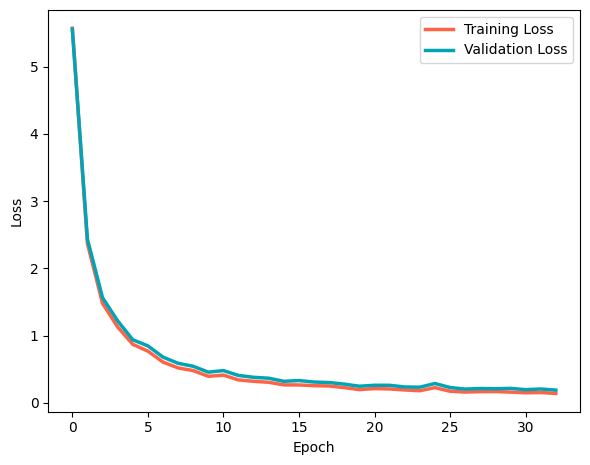

              precision    recall  f1-score   support

         cat       0.99      1.00      1.00      2486
         dog       1.00      0.98      0.99      1183

    accuracy                           0.99      3669
   macro avg       1.00      0.99      0.99      3669
weighted avg       0.99      0.99      0.99      3669



'              precision    recall  f1-score   support\n\n         cat       0.99      1.00      1.00      2486\n         dog       1.00      0.98      0.99      1183\n\n    accuracy                           0.99      3669\n   macro avg       1.00      0.99      0.99      3669\nweighted avg       0.99      0.99      0.99      3669\n'

In [10]:
_LoadData = LoadData(binary=True)
train = Train(lr=0.0005, bs=8, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
print("bs is " + str(8) + " and lr is " + str(0.0005))
train.train()
train.plot_loss_curves()
train.classification_report()

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 152MB/s]


Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 0.42140455722160963 	 Validation Loss: 0.29311518986587937
Epoch 2, Training Loss: 0.2262517528446472 	 Validation Loss: 0.19377605365994183
Epoch 3, Training Loss: 0.16373364796416592 	 Validation Loss: 0.13859134896293931
Epoch 4, Training Loss: 0.12667496696762418 	 Validation Loss: 0.11164412121086018
Epoch 5, Training Loss: 0.11119277645712314 	 Validation Loss: 0.08707681290157464
Epoch 6, Training Loss: 0.0994975464848761 	 Validation Loss: 0.07901274884605537
Epoch 7, Training Loss: 0.09423991108475172 	 Validation Loss: 0.06720989229886429
Epoch 8, Training Loss: 0.09099712590788207 	 Validation Loss: 0.060846259149358324
Epoch 9, Training Loss: 0.08695480324145731 	 Validation Loss: 0.05762130418873351
Epoch 10, Training Loss: 0.07729752018855399 	 Validation Loss: 0.055620370766795844
Epoch 11, Training Loss: 0.06914920978369596 	 Validation Loss: 0.04576381887106792
Epoch 12, Training Loss: 0.0700700858243457

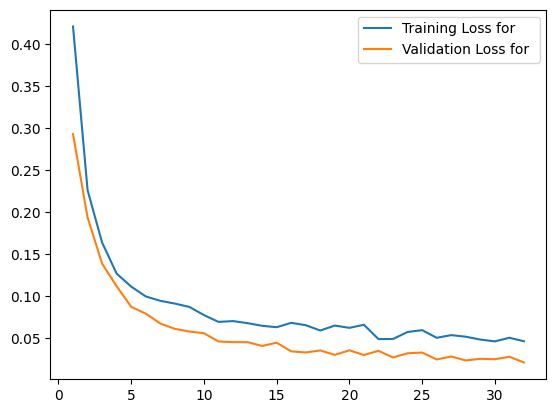

In [ ]:
for bs in [ 8]:
  for lr in [0.0005]:
    _LoadData = LoadData(binary=True)
    train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
    #train.pseudo_labels()
    print("bs is " + str(bs) + " and lr is " + str(lr))
    train.train()
    train.plot_loss_curves()

import matplotlib.pyplot as plt

epochs = np.arange(1, 32+1)

plt.plot(epochs, train.training_losses,  label='Training Loss for ')
plt.plot(epochs, train.validation_losses, label='Validation Loss for ')
plt.legend()

## Accuracy med 1% av 80% av tränings

Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 0.6921122819185257 	 Validation Loss: 0.6897396051664935
Epoch 2, Training Loss: 0.6814204156398773 	 Validation Loss: 0.6810256255486017
Epoch 3, Training Loss: 0.6616924107074738 	 Validation Loss: 0.6725224010162698
Epoch 4, Training Loss: 0.6554318964481354 	 Validation Loss: 0.6641323672879463
Epoch 5, Training Loss: 0.6487211883068085 	 Validation Loss: 0.6573521734687995
Epoch 6, Training Loss: 0.6199327558279037 	 Validation Loss: 0.6474539731111111
Epoch 7, Training Loss: 0.6052665561437607 	 Validation Loss: 0.6388806299260792
Epoch 8, Training Loss: 0.6179614663124084 	 Validation Loss: 0.629871620181096
Epoch 9, Training Loss: 0.5862627625465393 	 Validation Loss: 0.6198352529427281
Epoch 10, Training Loss: 0.5672891139984131 	 Validation Loss: 0.6111420176676351
Epoch 11, Training Loss: 0.5521276295185089 	 Validation Loss: 0.6027886700022876
Epoch 12, Training Loss: 0.5537946969270706 	 Validation Loss: 0.5

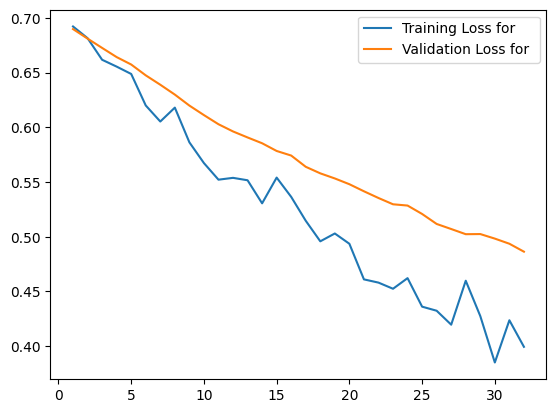

In [ ]:
bs = 8
lr = 0.0005
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8*0.01, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
#train.pseudo_labels()
print("bs is " + str(bs) + " and lr is " + str(lr))
train.train()

import matplotlib.pyplot as plt

epochs = np.arange(1, 32+1)

plt.plot(epochs, train.training_losses,  label='Training Loss for ')
plt.plot(epochs, train.validation_losses, label='Validation Loss for ')
plt.legend()


Hitta optimal lr

In [ ]:
bs = 8
lr = 0.0005

for lrMult in [ 10,100]:
  _LoadData = LoadData(binary=True)
  train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8*0.01, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
  #train.pseudo_labels()
  print(" lr is " + str(lr*lrMult))
  train.train()



Using gpu: True 
 lr is 0.005
Epoch 1, Training Loss: 0.6859598457813263 	 Validation Loss: 0.6831655797812097
Epoch 2, Training Loss: 0.6687897145748138 	 Validation Loss: 0.6779459764192738
Epoch 3, Training Loss: 0.6545509099960327 	 Validation Loss: 0.6713170511563881
Epoch 4, Training Loss: 0.6470277458429337 	 Validation Loss: 0.662199250788468
Epoch 5, Training Loss: 0.6334045678377151 	 Validation Loss: 0.6546842033195025
Epoch 6, Training Loss: 0.6185576617717743 	 Validation Loss: 0.6468409812473265
Epoch 7, Training Loss: 0.6064590811729431 	 Validation Loss: 0.6374310924725414
Epoch 8, Training Loss: 0.592655673623085 	 Validation Loss: 0.6289076065240053
Epoch 9, Training Loss: 0.5713455528020859 	 Validation Loss: 0.6211407476828478
Epoch 10, Training Loss: 0.5571041256189346 	 Validation Loss: 0.6140935965284391
Epoch 11, Training Loss: 0.5430381894111633 	 Validation Loss: 0.6068986532819398
Epoch 12, Training Loss: 0.5384269803762436 	 Validation Loss: 0.59991825828484

KeyboardInterrupt: 

## Accuracy med 10% av 80% av tränings


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:03<00:00, 24.1MB/s]


Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 0.6446326181695268 	 Validation Loss: 0.6099484282277846
Epoch 2, Training Loss: 0.5580429225354582 	 Validation Loss: 0.5387550913505982
Epoch 3, Training Loss: 0.4909329213000633 	 Validation Loss: 0.4844761342426341
Epoch 4, Training Loss: 0.4392776634242084 	 Validation Loss: 0.44195184428453865
Epoch 5, Training Loss: 0.4001069608572367 	 Validation Loss: 0.40116356127514197
Epoch 6, Training Loss: 0.34899347859459956 	 Validation Loss: 0.37508826849380333
Epoch 7, Training Loss: 0.3413144776950011 	 Validation Loss: 0.3512586737552199
Epoch 8, Training Loss: 0.29087529109941945 	 Validation Loss: 0.32243704480739016
Epoch 9, Training Loss: 0.2834678606407062 	 Validation Loss: 0.3079167624690162
Epoch 10, Training Loss: 0.2690369180730871 	 Validation Loss: 0.294746131629051
Epoch 11, Training Loss: 0.250922161582354 	 Validation Loss: 0.2733190909019252
Epoch 12, Training Loss: 0.24791508751946525 	 Validation Los

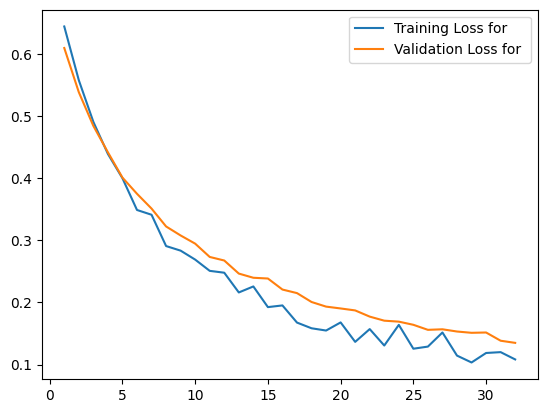

In [ ]:
bs = 8
lr = 0.0005
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8*0.1, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
#train.pseudo_labels()
print("bs is " + str(bs) + " and lr is " + str(lr))
train.train()

import matplotlib.pyplot as plt

epochs = np.arange(1, 32+1)

plt.plot(epochs, train.training_losses,  label='Training Loss for ')
plt.plot(epochs, train.validation_losses, label='Validation Loss for ')
plt.legend()


In [ ]:
bs = 8
lr = 0.0005

for lrMult in [ 10]:
  _LoadData = LoadData(binary=True)
  train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8*0.1, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
  #train.pseudo_labels()
  print(" lr is " + str(lr*lrMult))
  train.train()


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 83.7MB/s]


Using gpu: True 
 lr is 0.005
Epoch 1, Training Loss: 0.6431998497730976 	 Validation Loss: 0.607436503345841
Epoch 2, Training Loss: 0.554525921473632 	 Validation Loss: 0.5424374952445844
Epoch 3, Training Loss: 0.49315825749087977 	 Validation Loss: 0.49332944768037024
Epoch 4, Training Loss: 0.438724888337625 	 Validation Loss: 0.44565982566524803
Epoch 5, Training Loss: 0.39619530052752105 	 Validation Loss: 0.4179468832104712
Epoch 6, Training Loss: 0.3630683389869896 	 Validation Loss: 0.38273080597244913
Epoch 7, Training Loss: 0.34403744299669525 	 Validation Loss: 0.35925679444844244
Epoch 8, Training Loss: 0.3122214348735036 	 Validation Loss: 0.3379873974887985
Epoch 9, Training Loss: 0.2878304341354886 	 Validation Loss: 0.3315356564782318
Epoch 10, Training Loss: 0.2915857663831195 	 Validation Loss: 0.30291609422947907
Epoch 11, Training Loss: 0.26134604255895355 	 Validation Loss: 0.2864090088233396
Epoch 12, Training Loss: 0.24419490711109057 	 Validation Loss: 0.26013

KeyboardInterrupt: 

## Accuracy med 50% av 80% av tränings

Using gpu: True 
bs is 8 and lr is 0.0005
Epoch 1, Training Loss: 0.5118851974282576 	 Validation Loss: 0.4086741658224576
Epoch 2, Training Loss: 0.32329024414977303 	 Validation Loss: 0.28938980843277945
Epoch 3, Training Loss: 0.24349212379235288 	 Validation Loss: 0.22012893920359405
Epoch 4, Training Loss: 0.20331773117346608 	 Validation Loss: 0.18470563175345678
Epoch 5, Training Loss: 0.17695866468483987 	 Validation Loss: 0.15128084531296854
Epoch 6, Training Loss: 0.15102523887206032 	 Validation Loss: 0.13615608315213004
Epoch 7, Training Loss: 0.13734303305492454 	 Validation Loss: 0.12202614161145428
Epoch 8, Training Loss: 0.12084281687503276 	 Validation Loss: 0.10677022966758712
Epoch 9, Training Loss: 0.12295642888942815 	 Validation Loss: 0.09649544816626154
Epoch 10, Training Loss: 0.12653809541876873 	 Validation Loss: 0.09252069427537313
Epoch 11, Training Loss: 0.11562770382379708 	 Validation Loss: 0.07965715182945132
Epoch 12, Training Loss: 0.10374915932872049 

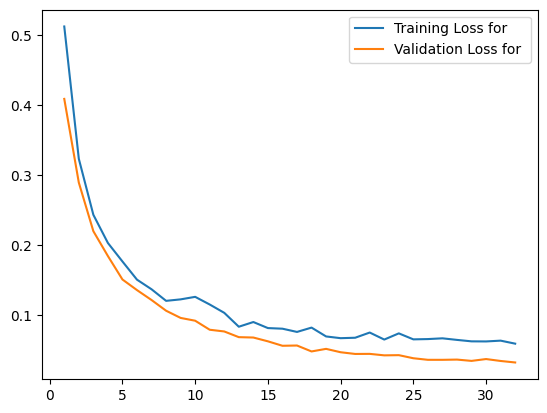

In [ ]:
bs = 8
lr = 0.0005
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8*0.5, binary=True, model=None, _LoadData=_LoadData, labeled_percent=1)
#train.pseudo_labels()
print("bs is " + str(bs) + " and lr is " + str(lr))
train.train()

import matplotlib.pyplot as plt

epochs = np.arange(1, 32+1)

plt.plot(epochs, train.training_losses,  label='Training Loss for ')
plt.plot(epochs, train.validation_losses, label='Validation Loss for ')
plt.legend()

# Using pseudo

Experiment with different learning rate for pseudo compared to training

## Comparing lrMult

In [ ]:
bs = 8
lr = 0.0005
labeled_percent = 0.01
for lrMult in [1, 10, 100]:
    _LoadData = LoadData(binary=True)
    train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=labeled_percent)
    train.pseudo_labels(lrMult)
    train.train()

true size = 2944
labeled train size = 29
unlabeled size = 2915


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 81.8MB/s]


Using gpu: True 
Pseudo training finished in 15.69 seconds
Pass first loop
pass second loop
2944
Epoch 1, Training Loss: 0.1825005177297103 	 Validation Loss: 1.206175287011201
Epoch 2, Training Loss: 0.09145330488125024 	 Validation Loss: 1.3803881580192272
Epoch 3, Training Loss: 0.07276374134538777 	 Validation Loss: 1.4576329715630931
Epoch 4, Training Loss: 0.06943954775393334 	 Validation Loss: 1.5698250036170383
Epoch 5, Training Loss: 0.062241779638418884 	 Validation Loss: 1.46307018067708
Epoch 6, Training Loss: 0.060243673031041195 	 Validation Loss: 1.6251822013974837
Epoch 7, Training Loss: 0.06109746683638229 	 Validation Loss: 1.5204862177513703
Epoch 8, Training Loss: 0.05479882819180721 	 Validation Loss: 1.4699321940045238
Epoch 9, Training Loss: 0.053433486214919904 	 Validation Loss: 1.50647497796656
Epoch 10, Training Loss: 0.052107854906985863 	 Validation Loss: 1.5175317082068194
Epoch 11, Training Loss: 0.054783600123419485 	 Validation Loss: 1.5729282653850059


## 1%

In [ ]:
_LoadData = LoadData(binary=True)

import matplotlib.pyplot as plt

epoch = 32

bs = 8
lr = 0.0005
labeled_percent = 0.01
lrMult  = 10
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=labeled_percent)
train.pseudo_labels(lrMult)






true size = 2944
labeled train size = 29
unlabeled size = 2915
Using gpu: True 
0.005
Pseudo training finished in 14.19 seconds
Pass first loop
Accuracy on test set for pseudo:  0.7677
pass second loop
2944


In [ ]:
train.train()

Epoch 1, Training Loss: 0.16379739610356805 	 Validation Loss: 0.1478712455086086
Epoch 2, Training Loss: 0.13919070491607746 	 Validation Loss: 0.13123390932931847
Epoch 3, Training Loss: 0.11849320483515444 	 Validation Loss: 0.11778673634904882
Epoch 4, Training Loss: 0.1182923213890045 	 Validation Loss: 0.1148002747365314
Epoch 5, Training Loss: 0.12241825632720618 	 Validation Loss: 0.10983346042263767
Epoch 6, Training Loss: 0.11727140048700992 	 Validation Loss: 0.1084183297605942
Epoch 7, Training Loss: 0.10590552975570419 	 Validation Loss: 0.09062008169965576
Epoch 8, Training Loss: 0.10341737165910435 	 Validation Loss: 0.08656328833540497
Epoch 9, Training Loss: 0.10002856062593586 	 Validation Loss: 0.0776474358028044
Epoch 10, Training Loss: 0.0990386541183714 	 Validation Loss: 0.09182200622339935
Epoch 11, Training Loss: 0.1048777785320493 	 Validation Loss: 0.09156658499420661
Epoch 12, Training Loss: 0.09587098127003232 	 Validation Loss: 0.08577824243769536
Epoch 13

0.9684

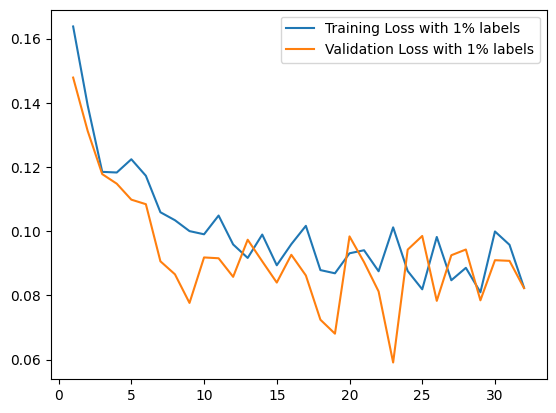

In [ ]:

epochs = np.arange(1, epoch+1)

plt.plot(epochs, train.training_losses,  label='Training Loss with 1% labels ' )
plt.plot(epochs, train.validation_losses, label='Validation Loss with 1% labels')
plt.legend()

## 10%

In [ ]:
epoch = 32

bs = 8
lr = 0.0005
labeled_percent = 0.1
lrMult  = 100
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=labeled_percent)
train.pseudo_labels(lrMult)





true size = 2944
labeled train size = 294
unlabeled size = 2650
Using gpu: True 
0.05
Pseudo training finished in 132.81 seconds
Pass first loop
Accuracy on test set for pseudo:  0.7146
pass second loop
2944


In [ ]:
train.train()

Epoch 1, Training Loss: 0.14739168881445314 	 Validation Loss: 0.044483146263162424
Epoch 2, Training Loss: 0.16899864201648174 	 Validation Loss: 0.03881438449360434
Epoch 3, Training Loss: 0.10490955032220237 	 Validation Loss: 0.044340835324339134
Epoch 4, Training Loss: 0.1595796605031372 	 Validation Loss: 0.04906114433988453
Epoch 5, Training Loss: 0.16669035504348478 	 Validation Loss: 0.040375116231223765
Epoch 6, Training Loss: 0.16882285893502205 	 Validation Loss: 0.041678814653606844
Epoch 7, Training Loss: 0.1495241386204471 	 Validation Loss: 0.04569517584946712
Epoch 8, Training Loss: 0.16462705642376718 	 Validation Loss: 0.030447627088745856
Epoch 9, Training Loss: 0.14709253659408789 	 Validation Loss: 0.04800888973627955
Epoch 10, Training Loss: 0.14583896461477722 	 Validation Loss: 0.03604349923783383
Epoch 11, Training Loss: 0.16459386977252854 	 Validation Loss: 0.03869180002457282
Epoch 12, Training Loss: 0.1458774776685344 	 Validation Loss: 0.03811466775994068

0.9902

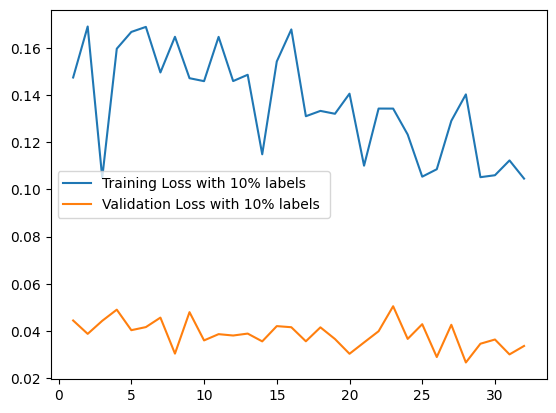

In [ ]:

epochs = np.arange(1, epoch+1)

plt.plot(epochs, train.training_losses,  label='Training Loss with 10% labels' )
plt.plot(epochs, train.validation_losses, label='Validation Loss with 10% labels ')
plt.legend()

## 50%

In [ ]:
epoch = 32

bs = 8
lr = 0.0005
labeled_percent = 0.5
lrMult  = 1
_LoadData = LoadData(binary=True)
train = Train(lr=lr, bs=bs, epochs=32, split_ratio=0.8, binary=True, model=None, _LoadData=_LoadData, labeled_percent=labeled_percent)
train.pseudo_labels(lrMult)





true size = 2944
labeled train size = 1472
unlabeled size = 1472
Using gpu: True 
0.0005
Pseudo training finished in 658.09 seconds
Pass first loop
Accuracy on test set for pseudo:  0.3992
pass second loop
2944


In [ ]:
train.train()

Epoch 1, Training Loss: 0.05879372714780797 	 Validation Loss: 0.041715839062817395
Epoch 2, Training Loss: 0.05863555917534066 	 Validation Loss: 0.031176897985658245
Epoch 3, Training Loss: 0.054353250282672336 	 Validation Loss: 0.03224890223076648
Epoch 4, Training Loss: 0.06108526305520765 	 Validation Loss: 0.03636315427011932
Epoch 5, Training Loss: 0.06528473370654746 	 Validation Loss: 0.031902362865841256
Epoch 6, Training Loss: 0.05076585829089669 	 Validation Loss: 0.02919813845326881
Epoch 7, Training Loss: 0.050164628768866154 	 Validation Loss: 0.027847885938725718
Epoch 8, Training Loss: 0.04391174575025418 	 Validation Loss: 0.03587579349582286
Epoch 9, Training Loss: 0.05479767220759126 	 Validation Loss: 0.02797792974414061
Epoch 10, Training Loss: 0.05111044661332372 	 Validation Loss: 0.026575316568715094
Epoch 11, Training Loss: 0.0450812670539523 	 Validation Loss: 0.025466237875187526
Epoch 12, Training Loss: 0.04542958061796051 	 Validation Loss: 0.026387117709

0.994

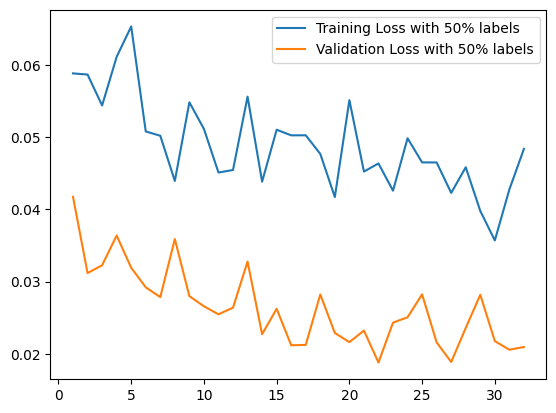

In [ ]:
epochs = np.arange(1, epoch+1)

plt.plot(epochs, train.training_losses,  label='Training Loss with 50% labels ')
plt.plot(epochs, train.validation_losses, label='Validation Loss with 50% labels')
plt.legend()
